In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [2]:
INPUT_PATH = 'D:/Datasets/penguinguy/%03d%03d.png'

In [3]:
TOTAL_IMAGE_PER_CAMERA = 40
THESHOLD_RATIO = 0.10

In [4]:
def get_diff_mask(camerea_id,current_shot):
    previous_shot = (current_shot - 1) % TOTAL_IMAGE_PER_CAMERA
    # read image
    image_prev_uint = cv2.imread(INPUT_PATH % (camerea_id,previous_shot)) 
    image_current_uint = cv2.imread(INPUT_PATH % (camerea_id,current_shot)) 
    # convert to RGB
    image_prev_uint = cv2.cvtColor(image_prev_uint,cv2.COLOR_BGR2RGB)
    image_current_uint = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
    # rotate
    image_prev_uint = cv2.rotate(image_prev_uint, cv2.ROTATE_90_CLOCKWISE)
    image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
    # convert to [0-1]
    image_prev =  image_prev_uint / 255.0
    image_current = image_current_uint / 255.0
    # difference mask between 2 images
    diff_mask = np.linalg.norm(image_current - image_prev, axis=-1)
    diff_mask = (diff_mask > THESHOLD_RATIO) * 1.0
    #remove noise from sensor (hope this not ruin image)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    denoised_mask = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel)
    return denoised_mask

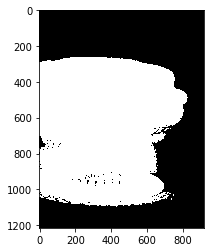

In [6]:
CAMERA_NUMBER = 3
foreground_prob = get_diff_mask(CAMERA_NUMBER,0)
for i in range(1,40):
    foreground_prob = cv2.bitwise_or(foreground_prob,get_diff_mask(CAMERA_NUMBER,i))
plt.imshow(foreground_prob,cmap='gray')

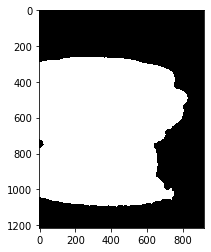

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
mask_closed = cv2.morphologyEx(foreground_prob, cv2.MORPH_CLOSE, kernel)
plt.imshow(mask_closed,cmap='gray')

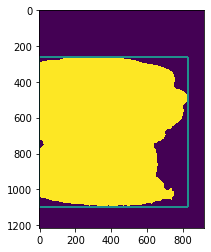

In [8]:
# find boundary (rectangle) of object 
mask_y, mask_x = np.nonzero(mask_closed)
min_x = np.min(mask_x)
max_x = np.max(mask_x)
min_y = np.min(mask_y)
max_y = np.max(mask_y)
mask_square = cv2.rectangle(mask_closed.copy(), (min_x,min_y), (max_x,max_y), (0.5), 10)
plt.imshow(mask_square)

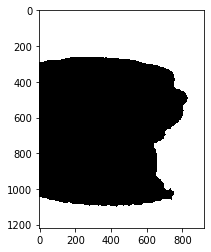

In [9]:
image_flooded = (mask_closed.copy() * 255.0).astype(np.uint8)
image_height, image_width = image_flooded.shape[:2]
flood_mask = np.zeros((image_height+2,image_width+2),dtype=np.uint8)
# top bar
if min_y != 0:
    for i in range(image_flooded.shape[1]):
        if image_flooded[0,i] != 255:
            cv2.floodFill(image_flooded, flood_mask, (0,i), 255)
# left bar
if min_x != 0:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,0] != 255:
            cv2.floodFill(image_flooded, flood_mask, (i,0), 255)

# right bar
most_right = image_flooded.shape[1] -1
if max_x != most_right:
    for i in range(image_flooded.shape[0]):
        if image_flooded[i,most_right] != 255:
            cv2.floodFill(image_flooded, flood_mask, (i,most_right), 255)

# bottom bar 
most_bottom = image_flooded.shape[0] -1
if max_y != most_bottom:
    for i in range(image_flooded.shape[1]):
        if image_flooded[most_bottom,i] != 255:
            cv2.floodFill(image_flooded, flood_mask, (most_bottom,i), 255)
plt.imshow(flood_mask,cmap='gray')

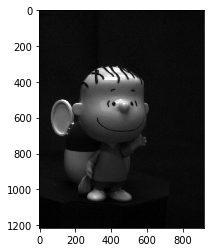

In [10]:
image_current_uint = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,1)) 
image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
image_gray = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray,cmap='gray')

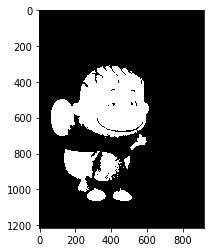

In [22]:
ret2,object_threshold = cv2.threshold(image_gray,35,255,cv2.THRESH_BINARY)
#ret2,object_threshold = cv2.threshold(image_gray,200,255,cv2.THRESH_TRIANGLE)
plt.imshow(object_threshold,cmap='gray')

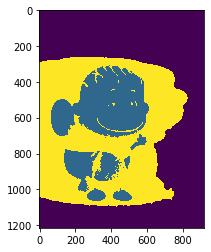

In [24]:
# create probability map
background_mask = flood_mask[1:-1,1:-1]
probability_map = np.zeros(image_gray.shape[:2])
probability_map[:,:] = cv2.GC_PR_FGD
probability_map[background_mask == 1] = cv2.GC_BGD
probability_map[object_threshold == 255] = cv2.GC_FGD
plt.imshow(probability_map)

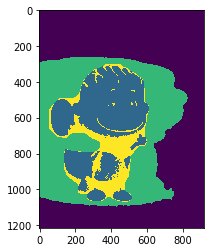

In [26]:
bgdmodel = np.zeros((1, 65), np.float64)
fgdmodel = np.zeros((1, 65), np.float64)
output = cv2.grabCut(image_current_uint.copy(), probability_map.astype(np.uint8), (0,0,0,0), bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)
plt.imshow(output[0])

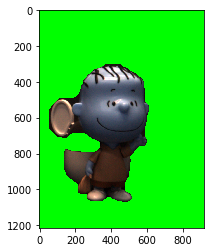

In [27]:
output_image = image_current_uint.copy()
output_image[output[0] == cv2.GC_BGD] = (0,255,0)
output_image[output[0] == cv2.GC_PR_BGD] = (0,255,0)
plt.imshow(output_image)

In [28]:
# %%
def whiten(im):
  H, W, C = im.shape
  # Flatten
  whitened_im = im.reshape(-1, C).astype('float')
  # Whiten the feature
  whitened_im -= np.mean(whitened_im, 0)
  whitened_im /= np.sqrt(np.mean(whitened_im ** 2, 0))
  return whitened_im.reshape(H, W, C)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


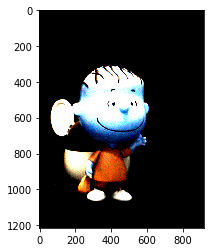

In [29]:
background_mask = flood_mask[1:-1,1:-1]
N_LABEL = 2
MAX_ITER = 200

feat = whiten(image_current_uint.copy())
H, W = image_current_uint.shape[:2]
plt.imshow(feat)


-0.7774779179768404

In [35]:
ret2,object_threshold = cv2.threshold(cv2.cvtColor(feat,cv2.COLOR_BGR2GRAY),35,255,cv2.THRESH_BINARY)
#ret2,object_threshold = cv2.threshold(image_gray,200,255,cv2.THRESH_TRIANGLE)
plt.imshow(object_threshold,cmap='gray')

error: OpenCV(3.4.7) c:\projects\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:90: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xe227985e::Set<1,-1,-1>,struct cv::impl::A0xe227985e::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [31]:
# %%
def rbf_kernel(dist, sigma=3):
  return np.exp(- np.sum(dist ** 2, 2) / sigma)

# Create pairwise conditional probability with nearest 4 neighbors
curr_feat = feat[1:H - 1, 1:W - 1]
top, bottom, left, right = np.zeros((H, W)), np.zeros(
    (H, W)), np.zeros((H, W)), np.zeros((H, W))

compatibility = np.array([[2, 0], [0, 2]])
top[1:H - 1,    1:W - 1] = rbf_kernel(curr_feat - feat[0:H - 2, 1:W - 1])
bottom[1:H - 1, 1:W - 1] = rbf_kernel(curr_feat - feat[2:H,     1:W - 1])
left[1:H - 1,   1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 0:W - 2])
right[1:H - 1,  1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 2:W])

# Create unary potential
logit = np.zeros((H, W, N_LABEL))
unary = np.zeros((H, W, N_LABEL))

In [32]:
# %%
# Set unary potential
unary[:,:] = [0.5, 0.5]
unary[background_mask == 1] = [0, 1]
unary[object_threshold == 255] = [1, 0]

In [33]:
# %%
for curr_iter in range(MAX_ITER):
  score = np.exp(logit)
  prob = score / (np.sum(score, 2, keepdims=True) + 1e-6)

  # Pass message
  logit[1:H - 1, 1:W - 1] = (
      left[  1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 0:W - 2] +
      right[ 1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 2:W] +
      top[   1:H - 1, 1:W - 1, np.newaxis] * prob[0:H - 2, 1:W - 1] +
      bottom[1:H - 1, 1:W - 1, np.newaxis] * prob[2:H,     1:W - 1]
  ).dot(compatibility) + unary[1:H - 1, 1:W - 1]

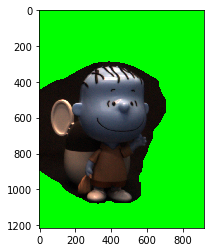

In [34]:
# %%
z = np.exp(logit[1:H - 1, 1:W - 1])
p = z / np.sum(z, 2, keepdims=True)
probability = p[:,:,0]


output_image = image_current_uint.copy()
m_h, m_w = output_image.shape[:2]
probability = cv2.resize(probability, (m_w,m_h))
output_image[probability <= 0.5] = (0,255,0)
plt.imshow(output_image)

#plt.imshow(p[:,:, 0])
plt.show()
